# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Importar Bibliotecas e Bases de Dados

In [90]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import time

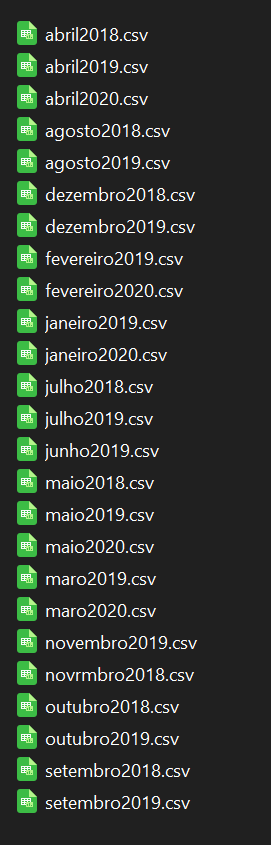

Como a base de dados estava separada em vários arquivos, foi necessário manipular esses arquivos e juntá-los em apenas um. Para isso, o seguinte código foi criado:



In [91]:
import warnings
warnings.filterwarnings('ignore')

meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul':7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

bases = []

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv',''))
    
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    bases.append(df)

base_airbnb = pd.concat(bases)
display(base_airbnb.head())

warnings.filterwarnings('default')

id                         listing_url       scrape_id last_scraped  \
0  14063  https://www.airbnb.com/rooms/14063  20180414160018   2018-04-14   
1  17878  https://www.airbnb.com/rooms/17878  20180414160018   2018-04-14   
2  24480  https://www.airbnb.com/rooms/24480  20180414160018   2018-04-14   
3  25026  https://www.airbnb.com/rooms/25026  20180414160018   2018-04-14   
4  31560  https://www.airbnb.com/rooms/31560  20180414160018   2018-04-14   

                                        name  \
0                       Living in a Postcard   
1          Very Nice 2Br - Copacabana - WiFi   
2           Nice and cozy near Ipanema Beach   
3  Beautiful Modern Decorated Studio in Copa   
4           NICE & COZY 1BDR - IPANEMA BEACH   

                                             summary  \
0  Besides the most iconic's view, our apartment ...   
1  Please note that special rates apply for New Y...   
2  My studio is located in the best  of Ipanema. ...   
3  Our apartment is a little gem, everyone loves ...   
4  This nice and clean 1 bedroom apartment is loc...   

                                               space  \
0                                                NaN   
1  - large balcony which looks out on pedestrian ...   
2  The studio is located at Vinicius de Moraes St...   
3  This newly renovated studio (last renovations ...   
4  This nice and clean 1 bedroom apartment is loc...   

                                         description experiences_offered  \
0  Besides the most iconic's view, our apartment ...                none   
1  Please note that special rates apply for New Y...                none   
2  My studio is located in the best  of Ipanema. ...                none   
3  Our apartment is a little gem, everyone loves ...                none   
4  This nice and clean 1 bedroom apartment is loc...                none   

                               neighborhood_overview  ...  \
0  Best and favorite neighborhood of Rio. Perfect...  ...   
1  This is the best spot in Rio. Everything happe...  ...   
2  The beach, the lagoon, Ipanema is a great loca...  ...   
3  Copacabana is a lively neighborhood and the ap...  ...   
4  Die Nachbarschaft von Ipanema ist super lebend...  ...   

  minimum_minimum_nights maximum_minimum_nights minimum_maximum_nights  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

  maximum_maximum_nights minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
0                    NaN                    NaN                     NaN   
1                    NaN                    NaN                     NaN   
2                    NaN                    NaN                     NaN   
3                    NaN                    NaN                     NaN   
4                    NaN                    NaN                     NaN   

   number_of_reviews_ltm calculated_host_listings_count_entire_homes  \
0                    NaN                                         NaN   
1                    NaN                                         NaN   
2                    NaN                                         NaN   
3                    NaN                                         NaN   
4                    NaN                                         NaN   

   calculated_host_listings_count_private_rooms  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   calculated_host_listings_count_shared_rooms  
0                                          NaN  
1                     

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
  1. IDs, Links de informações não relevantes para o modelo
  2. Colunas Repetidas ou extremamente parecidas com outras
  3. Colunas preenchidas com texto livre -> (Não será realizada análise de palavras)
  4. Colunas em que todos ou quase todos os valores são iguais
- Para isso, vamos criar um arquivo em .csv com os 1000 primeiros registros e fazer uma análise qualitativa

In [92]:
base_airbnb.head(1000).to_csv('primeiros_registros.csv')

In [93]:
print(list(base_airbnb.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

In [94]:
print(base_airbnb['experiences_offered'].value_counts())
# coluna com todos os valores iguais a 'none'

experiences_offered
none    902210
Name: count, dtype: int64


In [95]:
print(base_airbnb['host_acceptance_rate'].value_counts())
# coluna que a princípio, parece não possuir muita relevância para o modelo

host_acceptance_rate
100%    31697
0%       4744
50%      3781
99%      3320
67%      3140
        ...  
16%        22
15%        21
7%         20
51%        18
6%         11
Name: count, Length: 100, dtype: int64


In [96]:
print((base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count']).value_counts())
# Quase todos os valores em 'host_listings_count' são iguais a 'host_total_listings_count'. Logo, iremos excluir uma dessas colunas também.

True     901750
False       460
Name: count, dtype: int64


In [97]:
print(base_airbnb['square_feet'].isnull().sum())
# Há bastante valores nulos na coluna 'square_feet'. Logo, será excluída.

888162


### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [98]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type',
           'room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee',
           'guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy',
           'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
           'instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

In [99]:
# Selecionando apenas as colunas citadas acima (em 'colunas') do data frame inicial.
base_airbnb = base_airbnb.loc[: , colunas]
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores faltantes NaN foram excluídos da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000) vamos excluir as linhas que contém dados NaN

In [100]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300_000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(902210, 23)
host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [101]:
# Retirando os dados NaN do dataframe:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)

# Verificando se ainda há valores nulos no dataframe
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [102]:
print(base_airbnb.dtypes)
print('-'*100)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
----------------------------------------------------------------------------------------------------
host_is_superhost                                        

- Como Price e Extra_people estão sendo reconhecidos como objeto (ao invés de ser float) temos que mudar o tipo de variável da coluna

In [103]:
# price
base_airbnb['price'] = base_airbnb['price'].str.replace('$','')
base_airbnb['price'] = base_airbnb['price'].str.replace(',','')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

# extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$','')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',','')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
  
  1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
  2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acimda de Q3 + 1.5xAmplitude). Amplitude = Q3 -Q1
  3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir.

- Vamos Começar pelas colunas de preço (resultado final que queremos) e de extra_peolpe (também valor monetário). Esses são os valores numéricos contínuos
- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedroms, guests_included, etc)
- Por fim, vamos avaliar as colunas texto e definir quais categorias fazem sentido mantermos ou não.

Ex. de análise: Se o objetivo é ajudar a precificar um imóvel que está sendo disponibilizado, excluir outliers em host_listings_count pode fazer sentido. Agora, se uma empresa possui uma série de propriedades e quer comparar com outras empresas do tipo e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do modelo. É necessário sempre pensar no objetivo.

In [104]:
# Correlação entre as colunas 
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Purples')

# print(base_airbnb.corr(numeric_only=True))

<Axes: >

### Definição de funções para análise de outliers

Vamos definir algumas funções para ajudar na análise de ouliers das colunas

In [105]:
# Função para retornar os limites superior e inferior em uma determinada coluna
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5*amplitude, q3 + 1.5*amplitude


# Função para excluir outliers. Esta função recebe como parâmentro o dataframe e o nome da coluna, e utiliza a função de limites criada acima. 
# Retorna o dataframe com as linhas removidas e a quantidade de linhas removidas.
def excluir_outliers(df, nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    # Calula a quantidade de linhas removidas
    linhas_removidas = qtd_linhas - df.shape[0]
    return df, linhas_removidas

In [106]:
# Função para criar 2 boxplots. Um para todo o intervalo de valores e outro apenas com os valores dentro dos limites superior e inferior
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

# Função para criar histograma e verificar a distribuição dos valores
def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.histplot(coluna, kde=True, stat="density", kde_kws=dict(cut=3))

# Função para criar um gráfico de barras, que será útil em alguns casos
def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index , y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Para a coluna 'price', temos o seguinte:

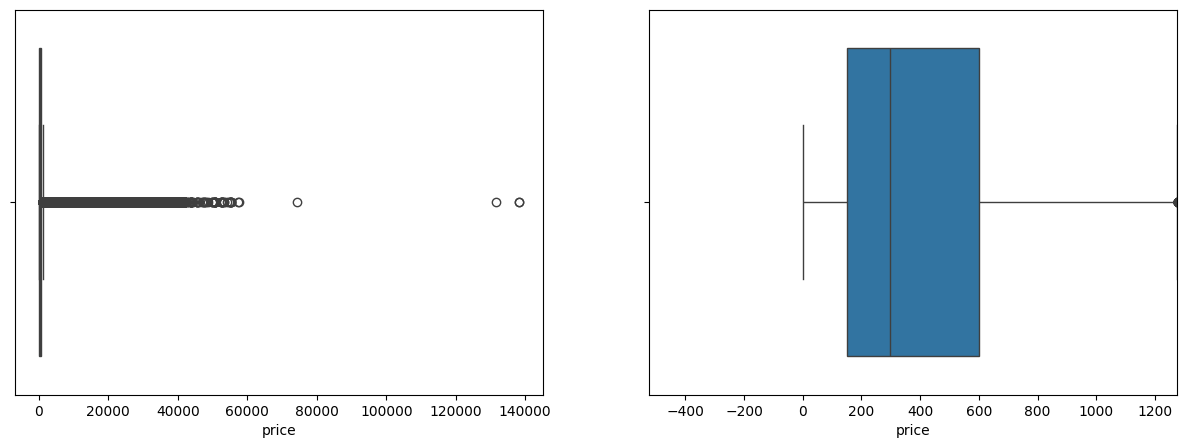

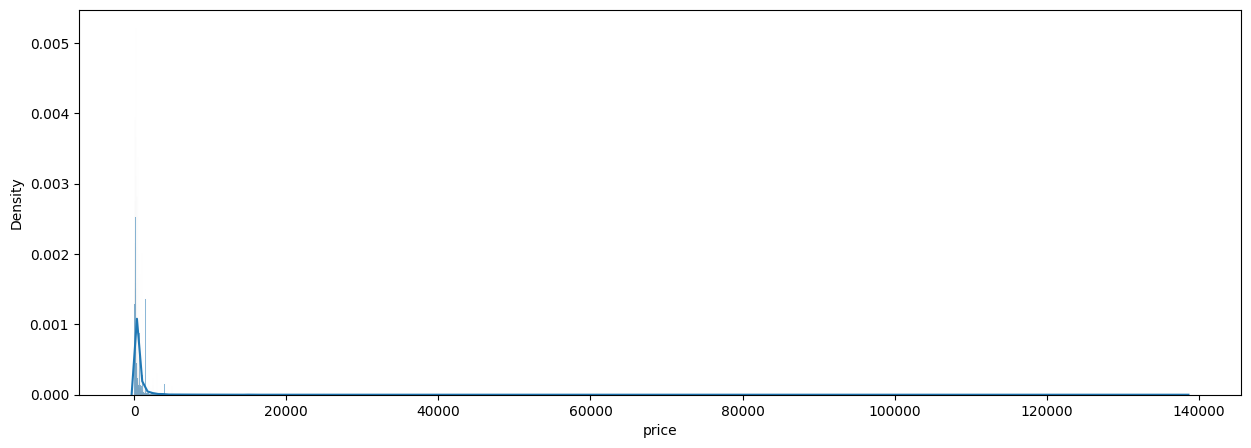

In [107]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [108]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


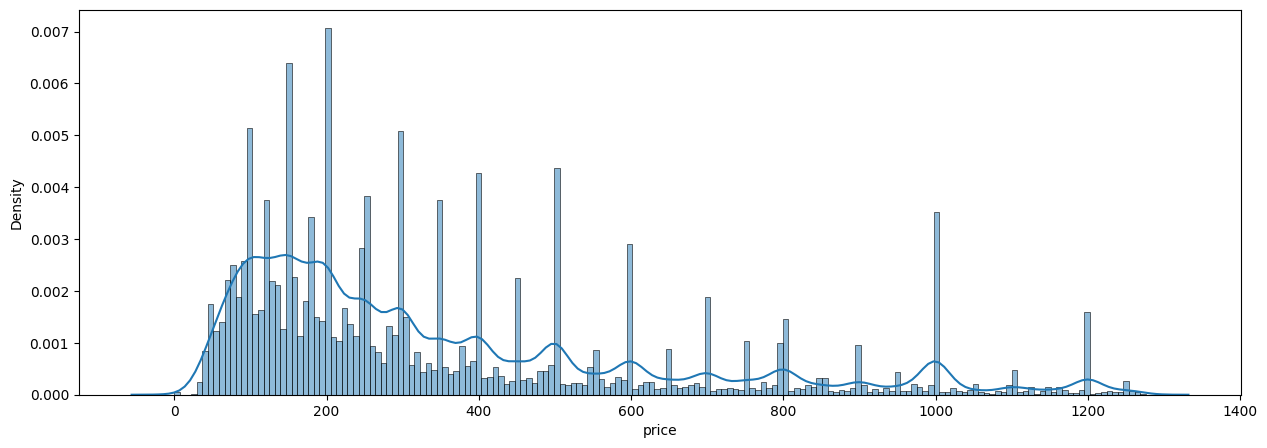

In [109]:
# Verificando o histograma para a coluna após a remoção dos outliers
histograma(base_airbnb['price'])

### Agora, para a coluna 'extra_people':

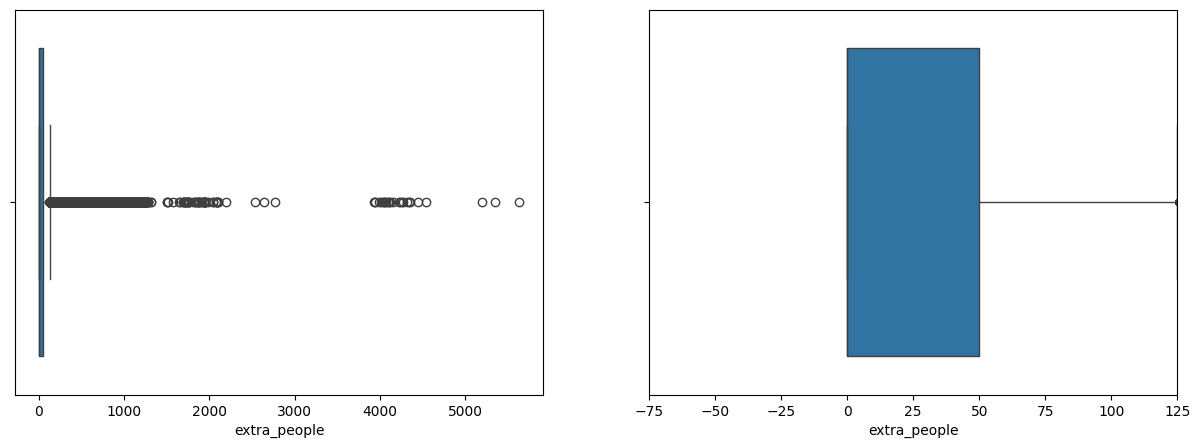

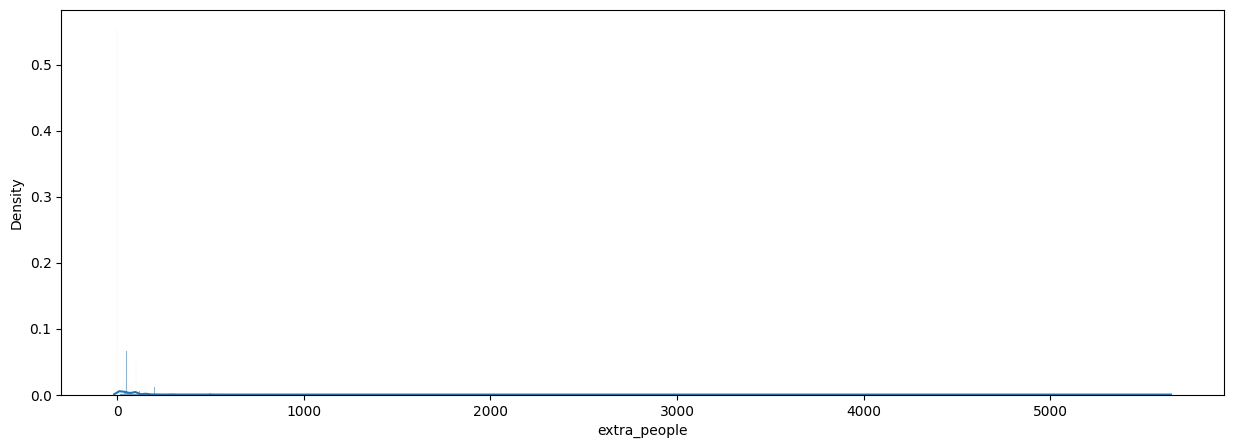

In [110]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [111]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


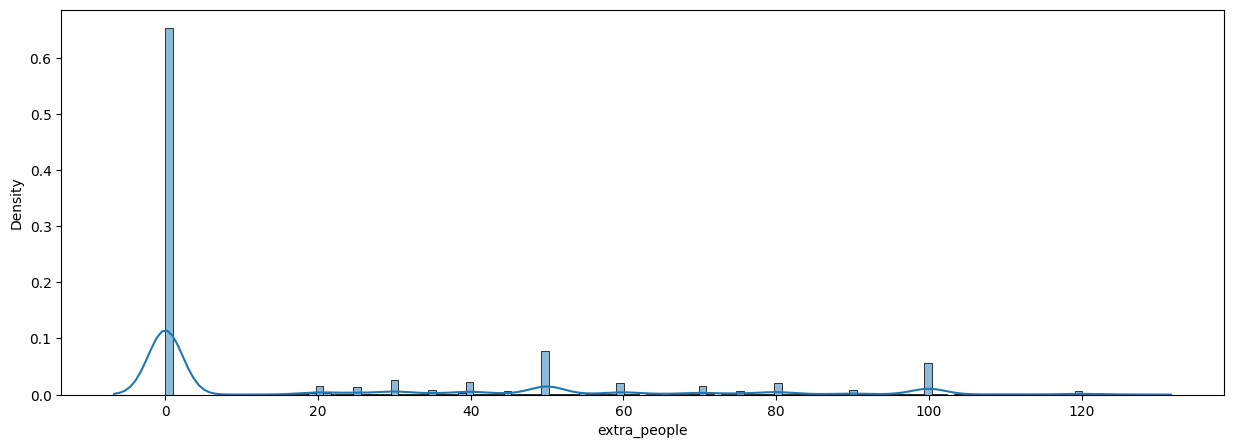

In [112]:
histograma(base_airbnb['extra_people'])

### Para 'host_listings_count':

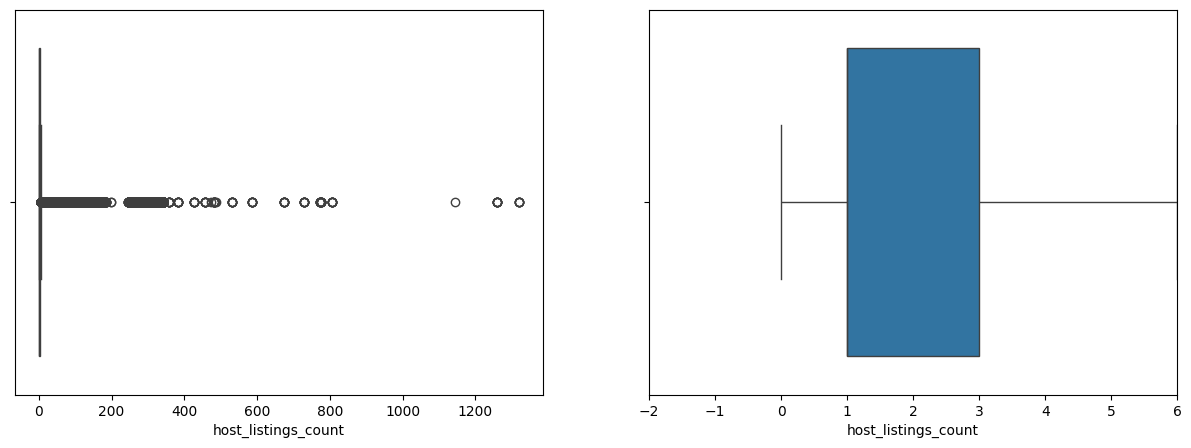

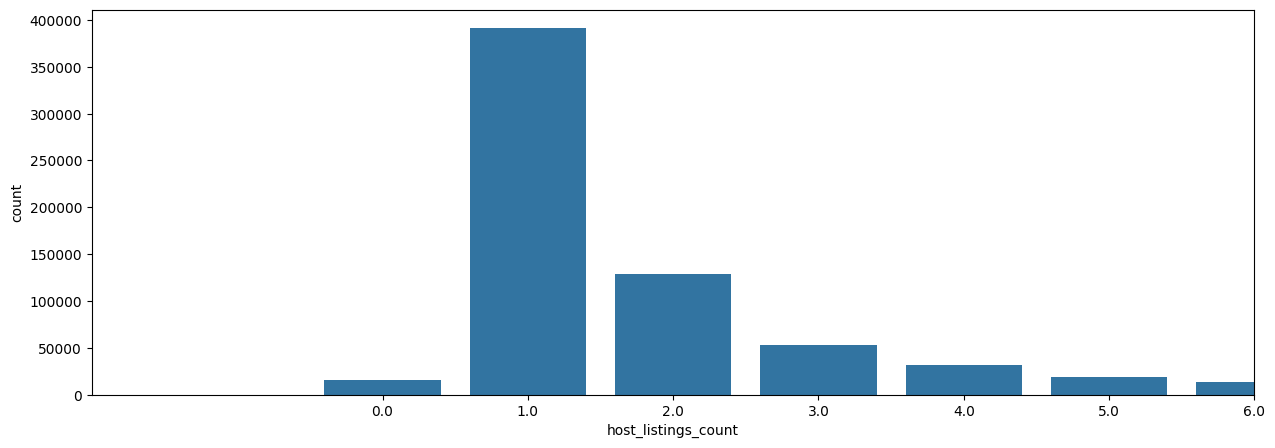

In [113]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetido do nosso projeto hosts com mais de 6 imóvis no airbnb não é o público alvo do objetivo do projeto (Imagino que sejam imobiliárias ou profissionais que gerenciam imóveis no airbnb)

In [114]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


### Para 'accommodates':

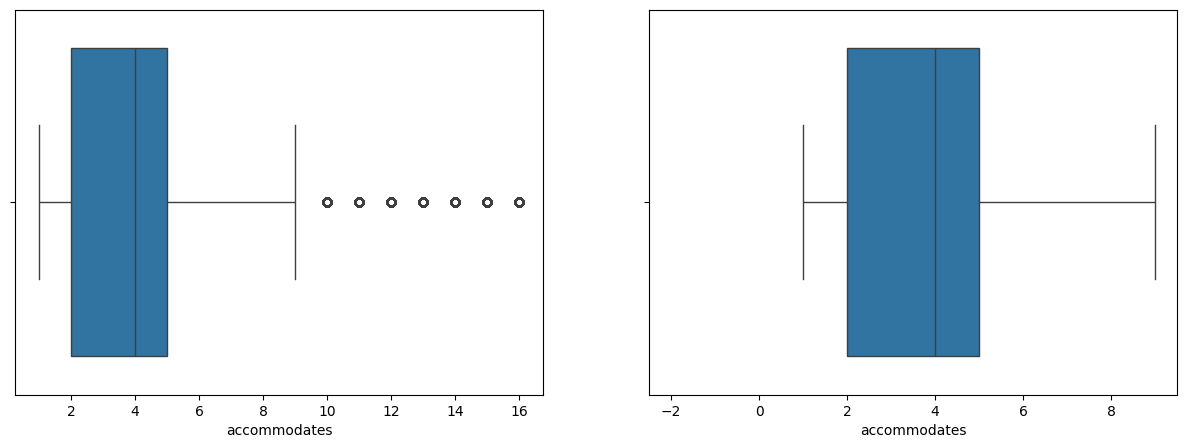

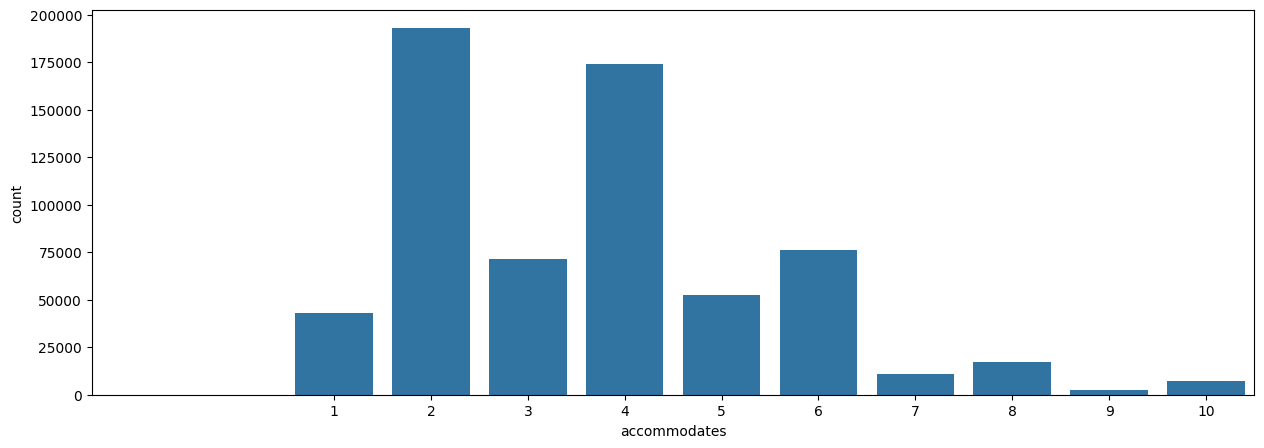

In [115]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [116]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### Para 'bathrooms':

In [117]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### Para 'bedrooms':

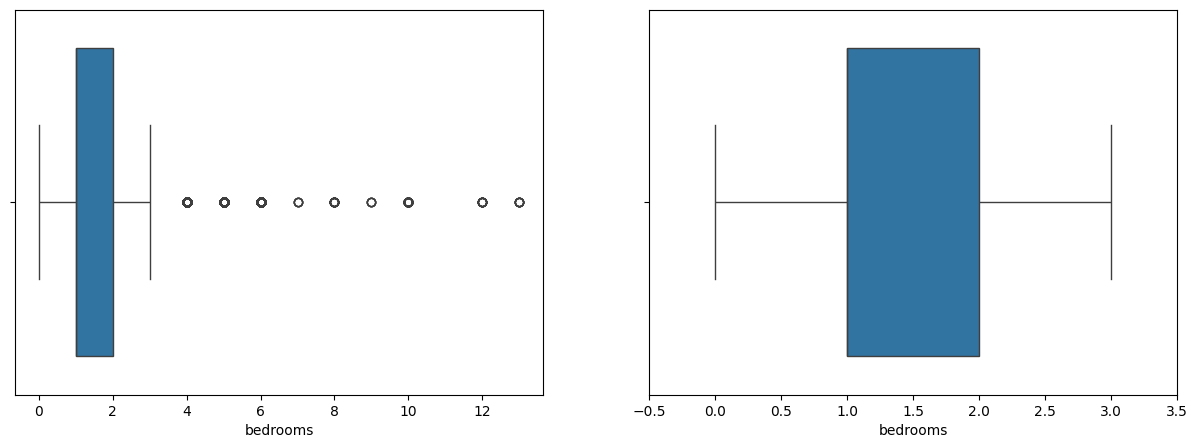

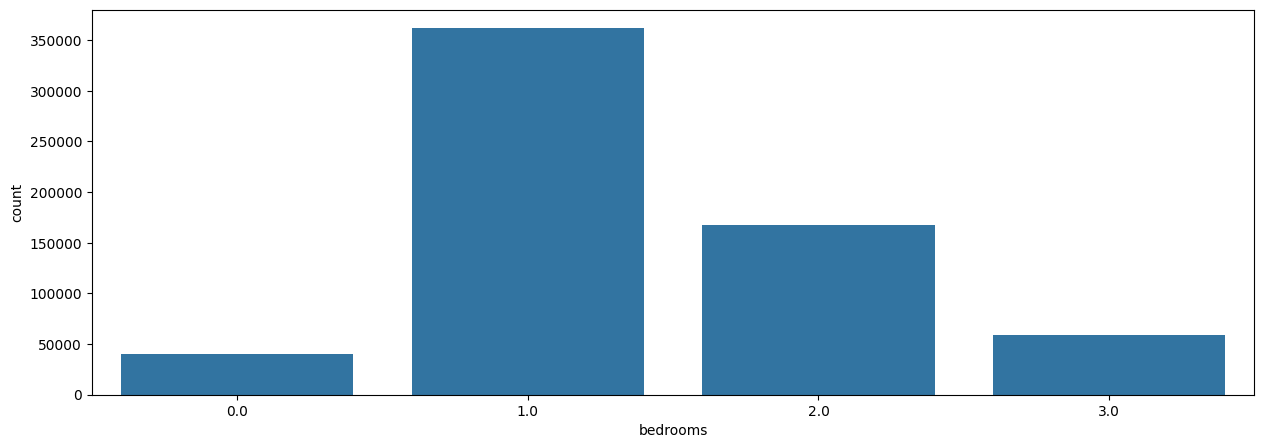

In [118]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [119]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds

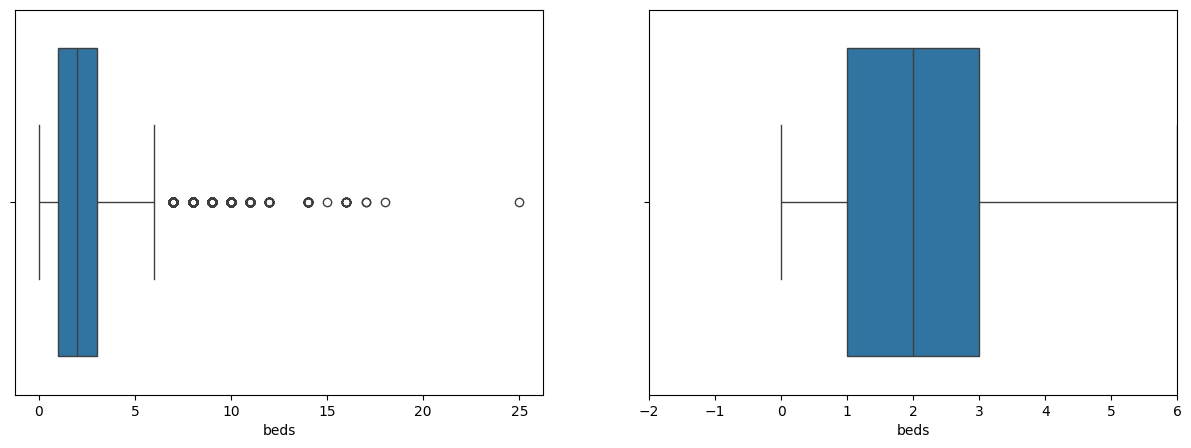

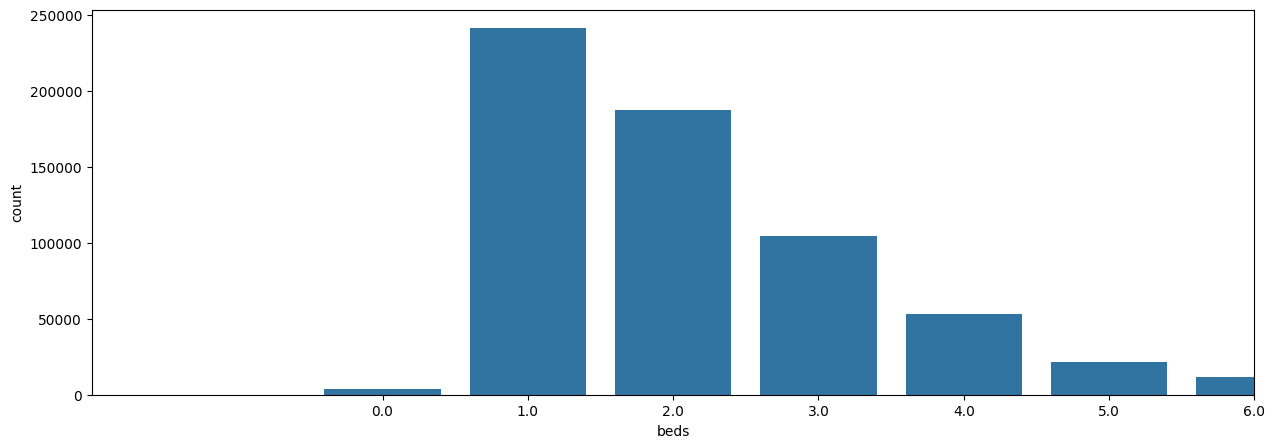

In [120]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [121]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### guests_included

(np.float64(1.0), np.float64(1.0))


<Axes: xlabel='guests_included', ylabel='count'>

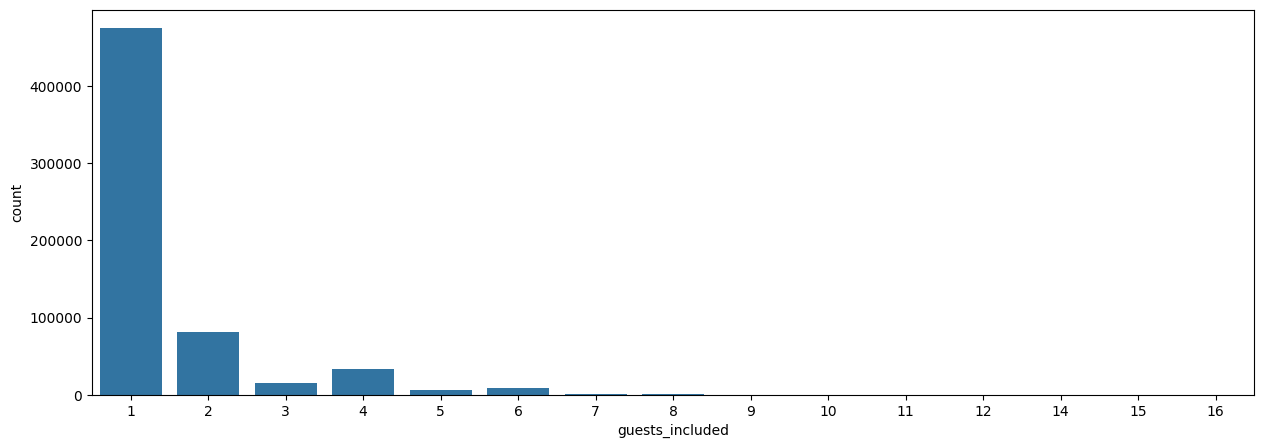

In [122]:
# Nesse caso, tanto o boxplot, quanto a função para gráfico de barras criados não retornam gráficos adequados para a análise. 
# Sendo assim, a análise em 'guests_included' será feita manualmente da seguinte forma:

# Exibindo os limites superior e inferior:
print(limites(base_airbnb['guests_included']))

# Criando o gráfico de barras para mostrar a distribuição dos valores da coluna
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão como 1 guest_included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [123]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

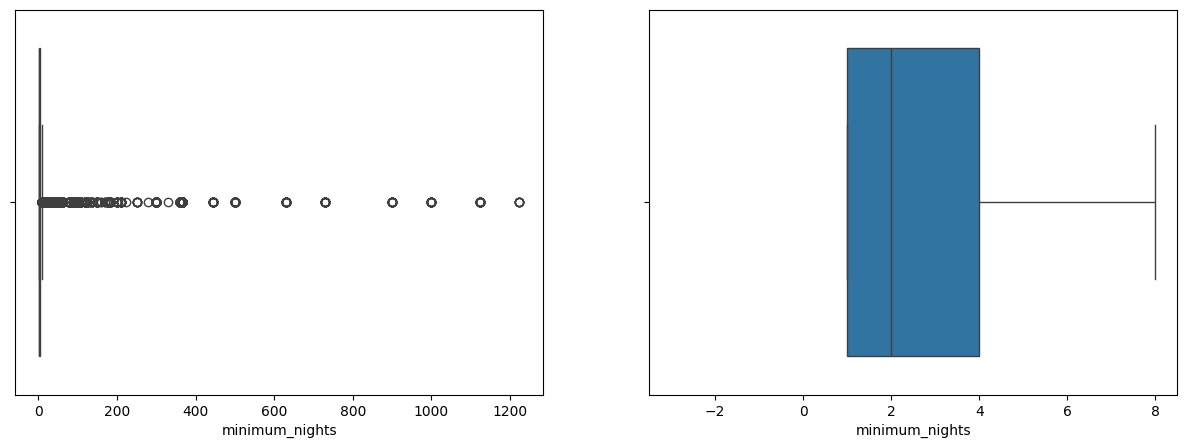

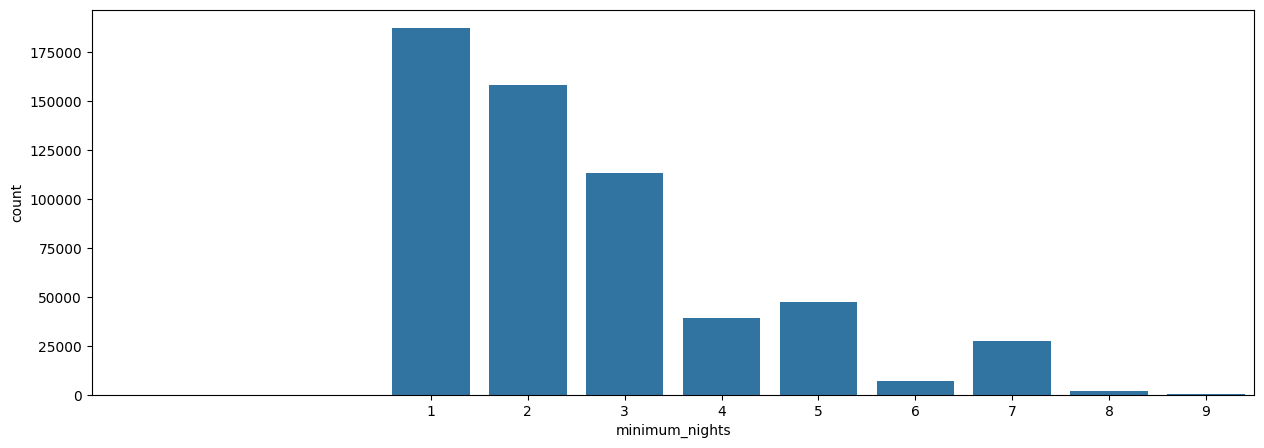

In [124]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [125]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### maximum_nights

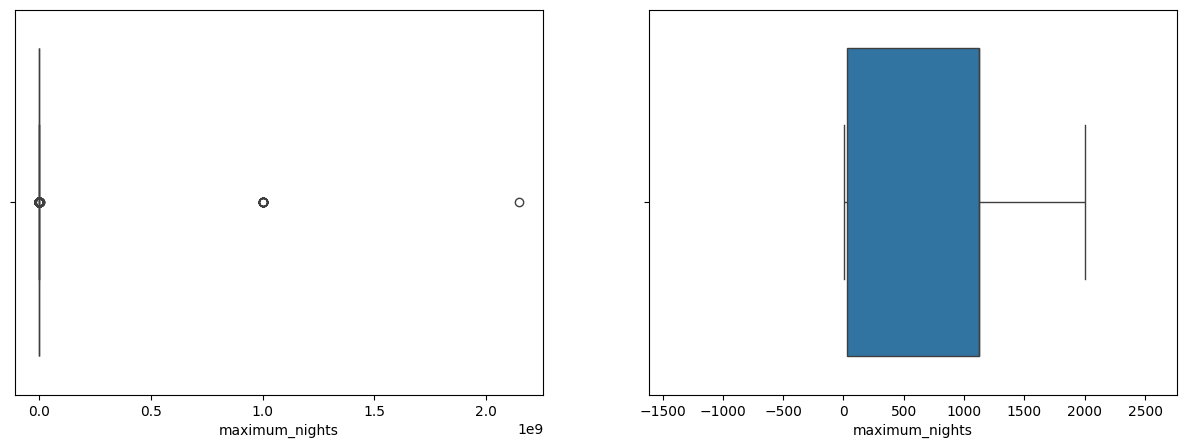

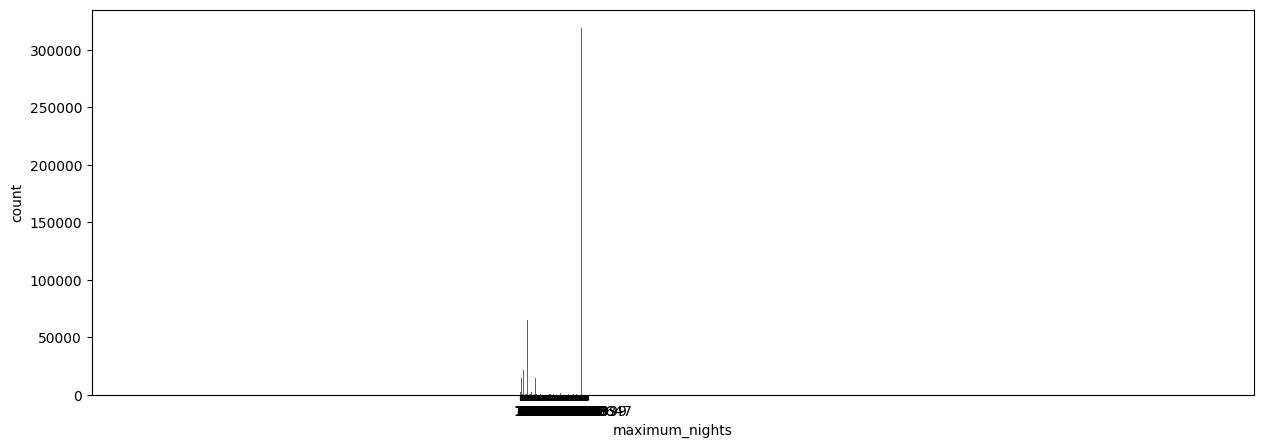

In [126]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [127]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews

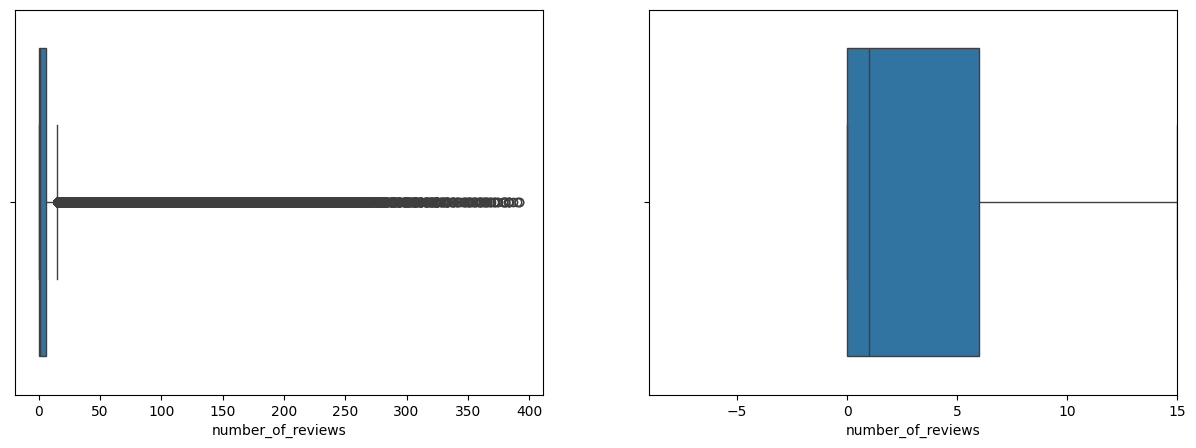

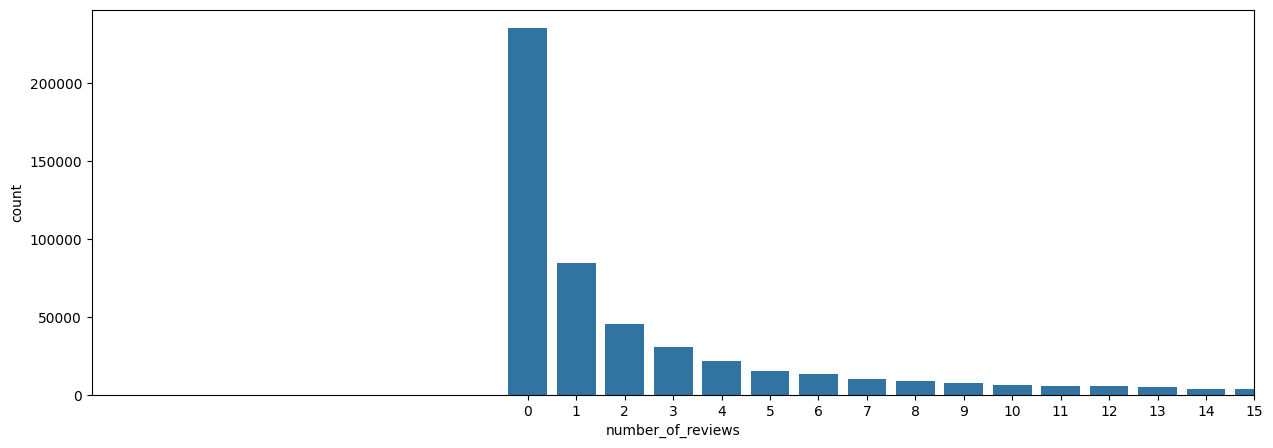

In [128]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [129]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

In [130]:
# Função criada apenas para verificar os limites inferior e superior e calcular quantas linhas serão removidas da coluna antes de remover.
def calcular_linhas(coluna):
    lim_inf, lim_sup = limites(coluna)
    print(f'Limite inferior: {lim_inf}, Limite superior: {lim_sup}')
    print(base_airbnb.loc[(coluna < lim_inf) | (coluna > lim_sup), :].shape[0])

calcular_linhas(base_airbnb['minimum_nights'])

Limite inferior: -2.0, Limite superior: 6.0
28919



## Tratamento de Colunas de Valores de Texto

### property_type

In [131]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x=base_airbnb['property_type'])
grafico.tick_params(axis='x', rotation=80)

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

Vamos agrupar todos os tipos de propriedade que possuem menos de 2000 listagems em uma categoria chamada "Outros", da seguinte forma:

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'In-law', 'Igloo', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


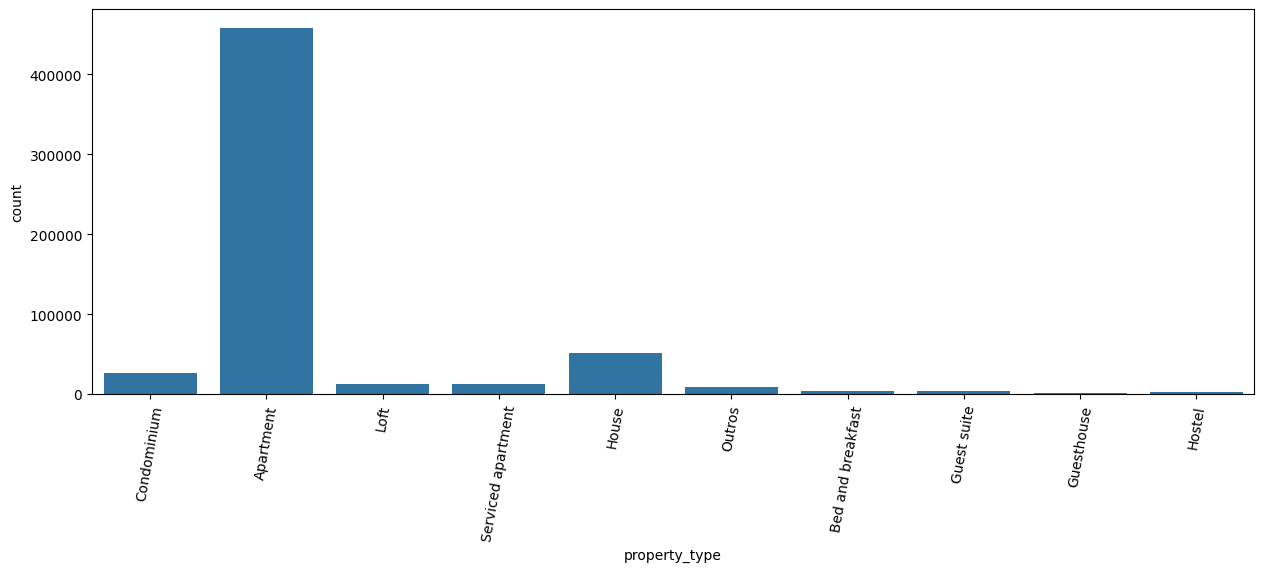

In [132]:
tabela_tipos_propriedade = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

# Verificar se existem menos de 2000 propriedades listadas para determinado tipo 
for tipo in tabela_tipos_propriedade.index:
    if tabela_tipos_propriedade[tipo] < 2000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

# Definindo o tipo de propriedade como 'Outros'
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())

# Exibindo gráfico com a distribuição dos tipos de propriedade após o agrupamento
plt.figure(figsize=(15,5))
grafico = sns.countplot(x=base_airbnb['property_type'])
grafico.tick_params(axis='x', rotation=80)

### room_type

In [133]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x=base_airbnb['room_type'])
grafico.tick_params(axis='x', rotation=80)

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


### bed_type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64
['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed    570643
Outros       11340
Name: count, dtype: int64


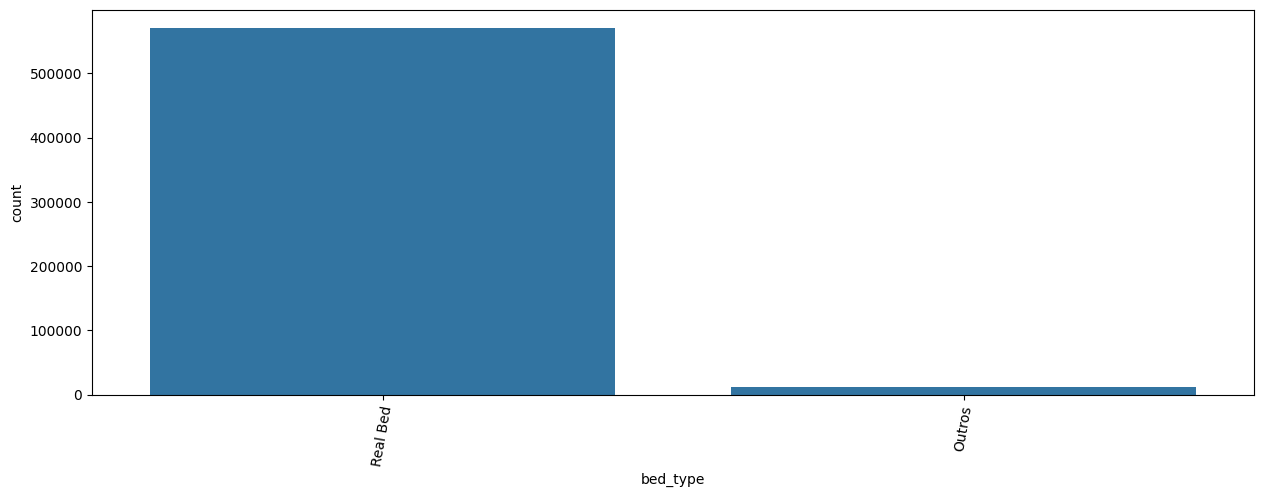

In [134]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x=base_airbnb['bed_type'])
grafico.tick_params(axis='x', rotation=80)# Agrupando categorias de bed_type
tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x=base_airbnb['bed_type'])
grafico.tick_params(axis='x', rotation=80)

Agruparemos todos os valores diferentes de 'Real Bed' na categoria 'Outros':

[]
bed_type
Real Bed    570643
Outros       11340
Name: count, dtype: int64


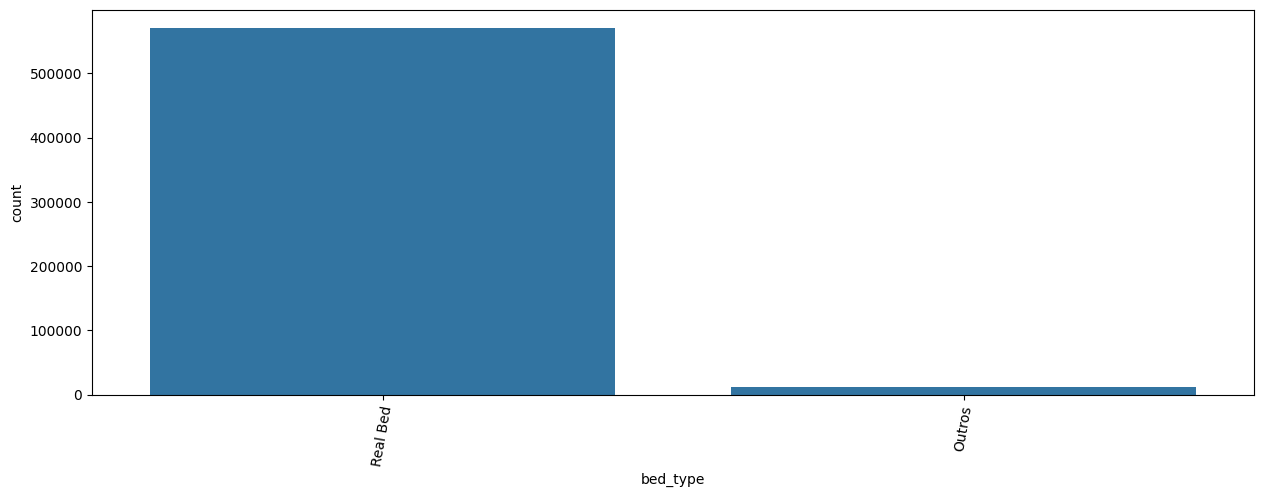

In [135]:
tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

# Agrupando categorias de bed_type
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x=base_airbnb['bed_type'])
grafico.tick_params(axis='x', rotation=80)

### cancellation_policy

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


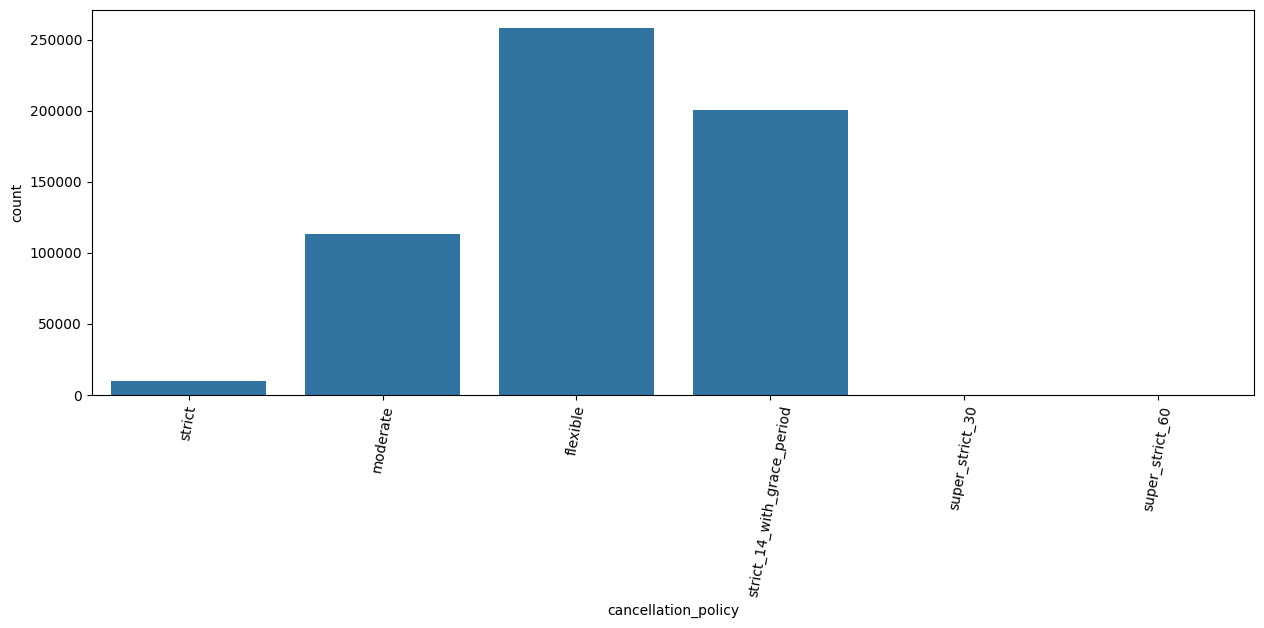

In [136]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])
grafico.tick_params(axis='x', rotation=80)

Agruparemos as categorias 'strict', 'super_strict_30' e 'super_stric_60' como sendo apenas 'strict'

['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64


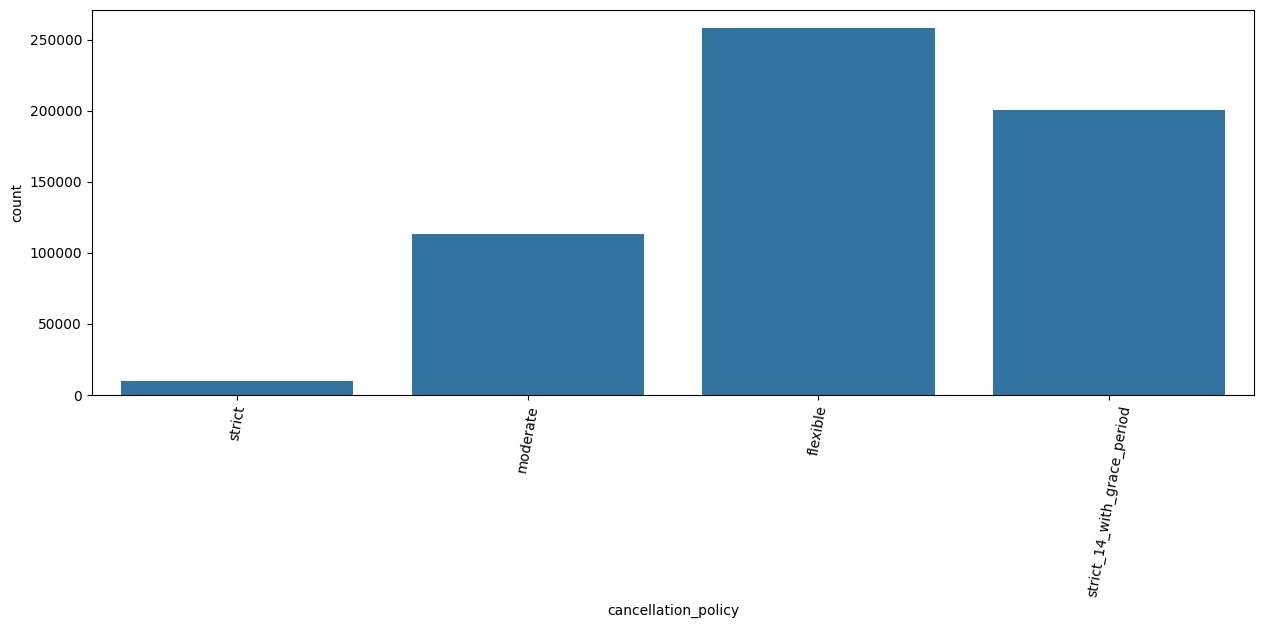

In [137]:
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

# Agrupando categorias de cancellation_policy
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])
grafico.tick_params(axis='x', rotation=80)

### amenities

Como tempos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escitas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo

In [138]:
# Realizando teste para verificar se está correto
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [139]:
# Criando a coluna 'n_amenities' com a contagem da quantidade de amenities
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

In [140]:
# Retirando a coluna amenities
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

Agora temos a coluna n_amenities que é uma coluna numérica. Logo, vamos tratar seus outliers

In [141]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [142]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


### Visualização de Mapa das Propriedades

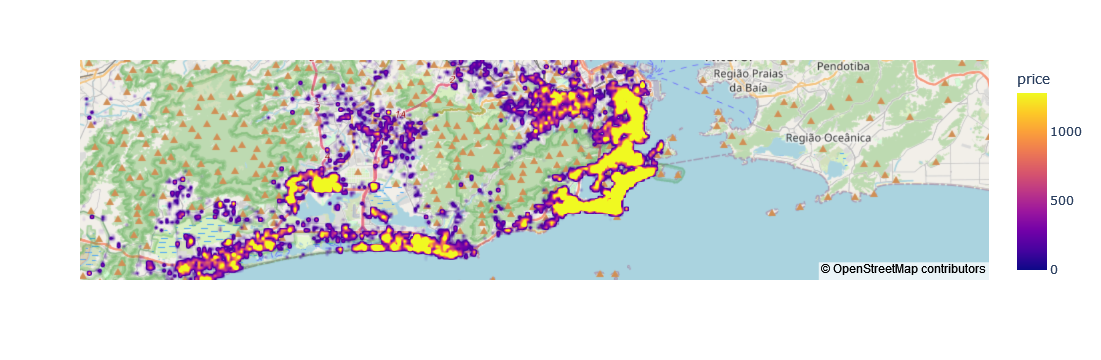

In [143]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                        center=centro_mapa, zoom=10, mapbox_style='open-street-map')
mapa.show()

### Encoding

Precisamos Ajustar as features para facilitar o trabalho futuro (features de categoria, true e false, etc)
- Features de valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [144]:
print(base_airbnb.iloc[0])

host_is_superhost                         t
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
extra_people                           51.0
minimum_nights                            4
instant_bookable                          t
is_business_travel_ready                  f
cancellation_policy                  strict
ano                                    2018
mes                                       4
n_amenities                              25
Name: 1, dtype: object


In [145]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod[coluna] = base_airbnb_cod[coluna].replace('t',1).replace('f',0)
print(base_airbnb_cod.dtypes)

host_is_superhost             int64
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
price                       float32
extra_people                float32
minimum_nights                int64
instant_bookable              int64
is_business_travel_ready      int64
cancellation_policy          object
ano                           int64
mes                           int64
n_amenities                   int64
dtype: object


C:\Users\Juanito\AppData\Local\Temp\ipykernel_15508\3509006716.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [146]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias, dtype=int)
display(base_airbnb_cod.head(10))

host_is_superhost  host_listings_count   latitude  longitude  \
1                   1                  2.0 -22.965919 -43.178962   
3                   0                  3.0 -22.977117 -43.190454   
4                   1                  1.0 -22.983024 -43.214270   
5                   1                  1.0 -22.988165 -43.193588   
6                   1                  1.0 -22.981269 -43.190457   
8                   0                  3.0 -22.921990 -43.183836   
18                  0                  1.0 -22.981808 -43.202074   
21                  0                  1.0 -22.981783 -43.200765   
23                  1                  3.0 -22.982817 -43.195712   
24                  0                  1.0 -22.984983 -43.191355   

    accommodates  bathrooms  bedrooms  beds  price  extra_people  ...  \
1              5        1.0       2.0   2.0  270.0          51.0  ...   
3              3        1.0       1.0   2.0  161.0          45.0  ...   
4              3        1.0       1.0   2.0  222.0          68.0  ...   
5              3        1.5       1.0   2.0  308.0          86.0  ...   
6              2        1.0       1.0   2.0  219.0          80.0  ...   
8              3        1.0       0.0   2.0  120.0           0.0  ...   
18             1        2.0       1.0   1.0   79.0           0.0  ...   
21             4        3.0       2.0   2.0  400.0           0.0  ...   
23             2        1.0       0.0   1.0  151.0          46.0  ...   
24             2        1.0       1.0   1.0   99.0          34.0  ...   

    room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
1                           1                     0                       0   
3                           1                     0                       0   
4                           1                     0                       0   
5                           1                     0                       0   
6                           1                     0                       0   
8                           1                     0                       0   
18                          0                     0                       1   
21                          1                     0                       0   
23                          1                     0                       0   
24                          0                     0                       1   

    room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                       0                0                  1   
3                       0                0                  1   
4                       0                0                  1   
5                       0                0                  1   
6                       0                0                  1   
8                       0                0                  1   
18                      0                0                  1   
21                      0                0                  1   
23                      0                0                  1   
24                      0                0                  1   

    cancellation_policy_flexible  cancellation_policy_moderate  \
1                              0                             0   
3                              0                             0   
4                              0                             0   
5                              0                             0   
6                              0                             0   
8                              0                             0   
18                             0                             0   
21                             0                             0   
23                             0                             0   
24                             0                             0   

    cancellation_policy_strict  \
1                            1   
3                            1   
4                            1   
5 

## Modelos de Previsão

- Métricas de avaliação

In [147]:
# Função para avaliar o modelo com base nos valores de teste com as seguintes métricas: Mean Absolute Error (MAE), Root Mean Square Error (RMSE) e R².
def avaliar_modelo(nome_modelo, y_teste, previsao):
    mae = mean_absolute_error(y_teste, previsao)
    r2 = r2_score(y_teste, previsao)
    rmse = np.sqrt(mean_squared_error(y_teste, previsao))
    
    return f'Modelo {nome_modelo}:\nMAE: {mae:.2f}\nR²: {r2:.2%}\nRSME: {rmse:.2f}'

- Escolha dos modelos a serem testados
  1. RandomForest
  2. LinearRegression
  3. Extra Tree
  4. XGBRegressor

In [149]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()
modelo_xgb = XGBRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          'XGBRegressor': modelo_xgb }

# Separando a base em x e y
y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

- Separar os dados em treino e teste + treino do modelo

In [150]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    # treinar
    inicio = time.time()
    modelo.fit(x_train, y_train)
    fim = time.time()
    # calular tempo de treinamento
    tempo_execucao = fim - inicio
    # testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))
    print(f"{time.strftime("%H:%M:%S",time.gmtime(tempo_execucao))}")
    print('-'*100)

Modelo RandomForest:
MAE: 14.54
R²: 97.22%
RSME: 44.23
00:02:48
----------------------------------------------------------------------------------------------------
Modelo LinearRegression:
MAE: 159.60
R²: 32.70%
RSME: 217.54
00:00:00
----------------------------------------------------------------------------------------------------
Modelo ExtraTrees:
MAE: 11.55
R²: 97.51%
RSME: 41.86
00:02:17
----------------------------------------------------------------------------------------------------
Modelo XGBRegressor:
MAE: 120.48
R²: 57.95%
RSME: 171.95
00:00:00
----------------------------------------------------------------------------------------------------


### Análise do Melhor Modelo

- Modelo escolhido como Melhor Modelo: ExtraTreesRegressor

    Esse foi o modelo com maior valor de R² e ao meosmo tempo, o menor valor de Root Mean Square Error(RMSE) e Mean Absolut Error(MAE). Como não tivemos uma grande diferença de velocidade de treino e previsão desse modelo comparando com o modelo RandomForest (que teve resultados de R² e RSME próximos), vamos escolher o Modelo ExtraTrees.
  
    Os modelos LinearRegression e XGBRegressor não obteviveram um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.

### Ajustes e Melhorias no Melhor Modelo

In [152]:
# Imprimindo as importâncias dadas a cada variável do modelo
print(modelo_et.feature_importances_)
print(x_train.columns)

[0.01329755 0.03984685 0.10403624 0.10129422 0.06899385 0.07432371
 0.11355772 0.05266595 0.08576847 0.06490575 0.02240897 0.
 0.01129677 0.0046993  0.08944419 0.01279853 0.0013163  0.00524933
 0.00066002 0.00095348 0.00061855 0.00715324 0.00216645 0.00238304
 0.00229571 0.06617106 0.00033539 0.00398094 0.00194784 0.0026786
 0.00265935 0.019567   0.01212995 0.00084463 0.00755104]
Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'ano',
       'mes', 'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel ro

0
bedrooms                                         0.113558
latitude                                         0.104036
longitude                                        0.101294
n_amenities                                      0.089444
extra_people                                     0.085768
bathrooms                                        0.074324
accommodates                                     0.068994
room_type_Entire home/apt                        0.066171
minimum_nights                                   0.064906
beds                                             0.052666
host_listings_count                              0.039847
instant_bookable                                 0.022409
cancellation_policy_flexible                     0.019567
host_is_superhost                                0.013298
property_type_Apartment                          0.012799
cancellation_policy_moderate                     0.012130
ano                                              0.011297
cancellation_policy_strict_14_with_grace_period  0.007551
property_type_House                              0.007153
property_type_Condominium                        0.005249
mes                                              0.004699
room_type_Private room                           0.003981
bed_type_Outros                                  0.002679
bed_type_Real Bed                                0.002659
property_type_Outros                             0.002383
property_type_Serviced apartment                 0.002296
property_type_Loft                               0.002166
room_type_Shared room                            0.001948
property_type_Bed and breakfast                  0.001316
property_type_Guesthouse                         0.000953
cancellation_policy_strict                       0.000845
property_type_Guest suite                        0.000660
property_type_Hostel                             0.000619
room_type_Hotel room                             0.000335
is_business_travel_ready                         0.000000

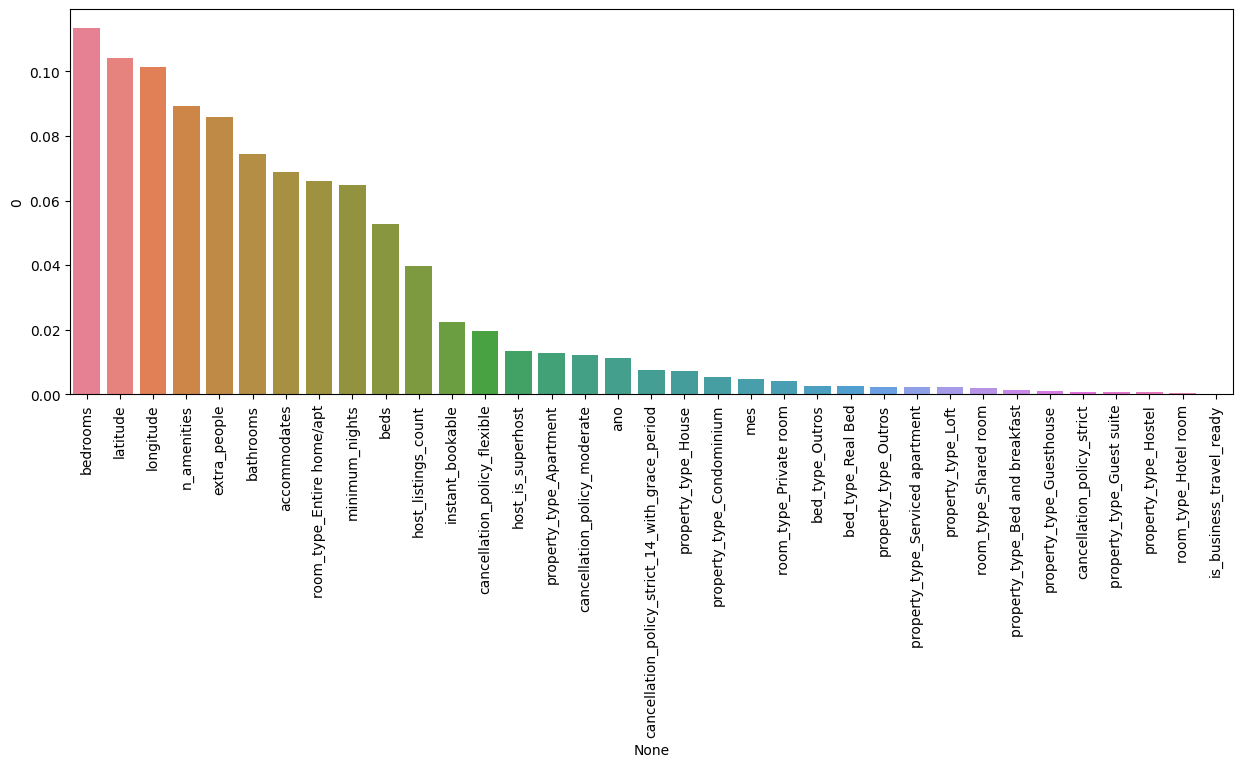

In [154]:
# Juntando as variáveis (x_train.columns) e as importâncias dadas para cada variável durante o treinamento do modelo (modelo_et.feature_importances_)
importancia_features = pd.DataFrame(data=modelo_et.feature_importances_, index=x_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

# Exibindo num gráfico para facilitar a visualização
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0], hue=importancia_features.index, palette="husl")
ax.tick_params(axis='x', rotation=90)

### Ajustes finais no modelo

- is_business_travel_ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamo excluir essa feature e testar o modelo sem ela.

In [155]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

In [156]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

inicio = time.time()
modelo_et.fit(x_train, y_train)
fim = time.time()
tempo_execucao = fim - inicio
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))
print(f"{time.strftime("%H:%M:%S",time.gmtime(tempo_execucao))}")

Modelo ExtraTrees:
MAE: 11.55
R²: 97.50%
RSME: 41.92
00:02:17


In [157]:
# Criando cópia do base_airbnb_cod para testar mais modificações
base_teste = base_airbnb_cod.copy()

# Retirando todas as colunas relativas ao tipo de cama ('bed_type')
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)

y = base_teste['price']
x = base_teste.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

In [158]:
inicio = time.time()
modelo_et.fit(x_train, y_train)
fim = time.time()
tempo_execucao = fim - inicio
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))
print(f"{time.strftime("%H:%M:%S",time.gmtime(tempo_execucao))}")

Modelo ExtraTrees:
MAE: 11.58
R²: 97.49%
RSME: 42.04
00:02:12


In [159]:
importancia_features = pd.DataFrame(data=modelo_et.feature_importances_, index=x_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

0
bedrooms                                         0.121023
latitude                                         0.105190
longitude                                        0.102719
n_amenities                                      0.089835
extra_people                                     0.085758
bathrooms                                        0.072064
accommodates                                     0.069708
minimum_nights                                   0.065543
room_type_Entire home/apt                        0.060889
beds                                             0.052950
host_listings_count                              0.040148
instant_bookable                                 0.022091
cancellation_policy_flexible                     0.019435
host_is_superhost                                0.013391
property_type_Apartment                          0.012838
cancellation_policy_moderate                     0.012150
ano                                              0.011363
cancellation_policy_strict_14_with_grace_period  0.007714
property_type_House                              0.007115
property_type_Condominium                        0.005203
mes                                              0.004713
room_type_Private room                           0.004589
property_type_Outros                             0.002437
property_type_Serviced apartment                 0.002273
property_type_Loft                               0.002268
room_type_Shared room                            0.001852
property_type_Bed and breakfast                  0.001310
property_type_Guesthouse                         0.000953
cancellation_policy_strict                       0.000854
property_type_Guest suite                        0.000678
property_type_Hostel                             0.000635
room_type_Hotel room                             0.000309

### Deploy do Projeto

In [162]:
# Juntando as variáveis x e y em um só dataframe e exportando no formato .csv
x['price'] = y
x.to_csv('dados.csv')

In [163]:
# Perpetuando o modelo em um arquivo
import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']